In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [58]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [49]:
import tensorflow_datasets as tfds
ds = tfds.load('fashion_mnist', split='train')


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\ujwal\tensorflow_datasets\fashion_mnist\incomplete.EWREDX_3.0.1\fashion_mnist-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\ujwal\tensorflow_datasets\fashion_mnist\incomplete.EWREDX_3.0.1\fashion_mnist-test.tfrecord…

Dataset fashion_mnist downloaded and prepared to C:\Users\ujwal\tensorflow_datasets\fashion_mnist\3.0.1. Subsequent calls will reuse this data.


In [50]:
ds.as_numpy_iterator().next()['label']

2

In [52]:
dataiterator = ds.as_numpy_iterator()
dataiterator.next()['image']

array([[[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 18],
        [ 77],
        [227],
        [227],
        [208],
        [210],
        [225],
        [216],
        [ 85],
        [ 32],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 61],
        [100],
        [ 97],
        [ 80],
        [ 57],
        [117],
        [227],
        [238],
        [115],
        [ 49],
        [ 78],
        [106],
        [108],
        [ 71],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 81],
        [105],
        [ 80],
        [ 69],
      

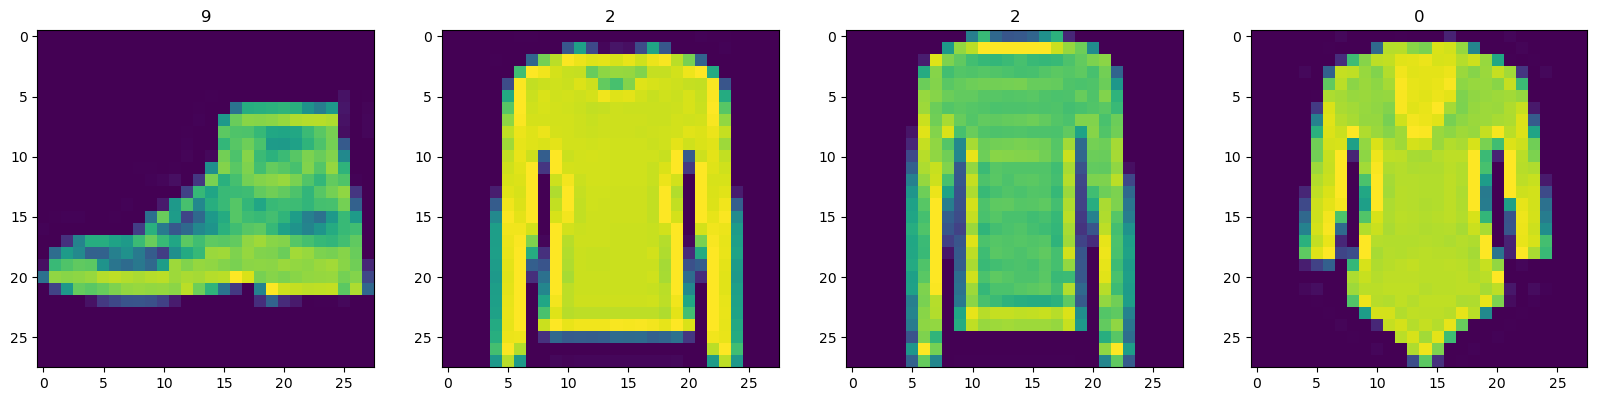

In [54]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample = dataiterator.next()
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(sample['image']))
    ax[idx].title.set_text(sample['label'])

In [55]:
def scale_images(data): 
    image = data['image']
    return image / 255

In [56]:

ds = ds.map(scale_images) 
ds = ds.cache()
ds = ds.shuffle(60000)
ds = ds.batch(128)
ds = ds.prefetch(64)

In [57]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

In [59]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense,Flatten,Reshape,LeakyReLU,Dropout,UpSampling2D

In [ ]:
#generator
def build_generator():
    model = Sequential()
    # Takes in random values and reshapes it to 7x7x128
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))
    
    # Upsampling
    #build up to 28*28
    model.add(UpSampling2D())#doubles the size to 14*14*128
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))#final (28*28*1)
    return model

In [72]:
generator=build_generator()

In [73]:
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_2 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                      

In [83]:
img=generator.predict(np.random.randn(4,128,1))

1/1 [==============================] - 0s 24ms/step


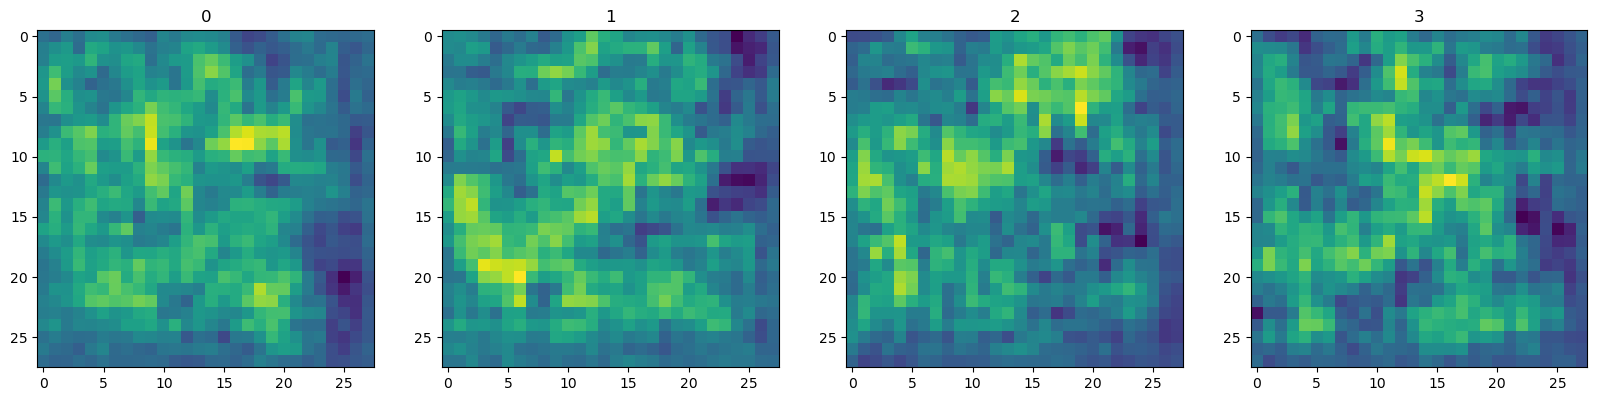

In [84]:

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(img): 
    
    ax[idx].imshow(np.squeeze(img))
    
    ax[idx].title.set_text(idx)

In [85]:
img.shape

(28, 28, 1)

In [76]:
#discriminator
def build_discriminator():
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model 

In [78]:
discriminator=build_discriminator()
discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_5 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_6 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 16, 16, 128)      

In [82]:
img.shape

(28, 28, 1)

In [86]:
discriminator.predict(np.expand_dims(img,0))

1/1 [==============================] - 0s 299ms/step


array([[0.5026722]], dtype=float32)

<h3>construct the custom training loop since the generator and discriminator has to be trained simultaneously and together that not one of it becomes extremely powerlful than others and leaves it behind, so adding some random noises to slow down the discriminator so generator gets more time to perfect</h3>

In [87]:
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam

In [88]:
d_loss=BinaryCrossentropy()
g_loss=BinaryCrossentropy()
g_opt=Adam(lr=0.0001)
d_opt=Adam(lr=0.00001)


c:\Users\ujwal\anaconda3\envs\py310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [90]:
tf.random.normal((6,128,1))#type of inout generator accepts since it accepts latent_dims of one dim

<tf.Tensor: shape=(6, 128, 1), dtype=float32, numpy=
array([[[ 1.08361101e+00],
        [-1.35508788e+00],
        [ 2.01781058e+00],
        [-8.27181712e-02],
        [ 1.35637119e-01],
        [ 9.39545751e-01],
        [-9.55432117e-01],
        [-1.13098752e+00],
        [-1.12253499e+00],
        [ 1.77743196e+00],
        [-1.56685936e+00],
        [-9.89612222e-01],
        [-2.75727659e-01],
        [-7.29138494e-01],
        [ 7.76123166e-01],
        [ 1.67768037e+00],
        [-9.85123888e-02],
        [-1.48138809e+00],
        [-1.10734761e-01],
        [ 1.19175100e+00],
        [-6.26271307e-01],
        [ 5.54181039e-01],
        [-9.19539750e-01],
        [ 1.17676544e+00],
        [-3.29912528e-02],
        [ 1.61372137e+00],
        [-2.23083064e-01],
        [ 1.18984592e+00],
        [-9.13029313e-01],
        [-3.07401121e-01],
        [ 8.38042021e-01],
        [ 1.32156223e-01],
        [ 2.76467860e-01],
        [ 5.25580108e-01],
        [-1.03561127e+00],
  

In [92]:
class FashionGAN(tf.keras.Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class 
        super().__init__(*args, **kwargs)
        
        # Create attributes for gen and disc
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):
        # Get the data 
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape: 
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - BINARYCROSS 
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Apply backpropagation - nn learn 
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator 
        with tf.GradientTape() as g_tape: 
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
                                        
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [93]:
fashgan=FashionGAN(generator,discriminator)

In [94]:
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

<h3>build the custom call back for saving images of generator</h3>

In [95]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [96]:
class ModelMonitor(Callback):
    def __init__(self,num_img=3,latent_dim=128):
        self.num_img=num_img
        self.latent_dim=latent_dim
    
    def on_epoch_end(self,epoch,logs=None):
        random_latent_vectors=tf.random.uniform((self.num_img,self.latent_dim,1))#inside another backet because its a single attribute of shape:
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('generated_images', f'generated_img_{epoch}_{i}.png'))

<h2>advised epoch is 2000-4000 since we cant train that big model we can derive the weights of 2000 epoch trained model for testing<h2>

In [97]:
# Recommend 2000 epochs
hist = fashgan.fit(ds, epochs=20, callbacks=[ModelMonitor()])

Epoch 1/20
469/469 [==============================] - 239s 484ms/step - d_loss: 0.5317 - g_loss: 0.9029
Epoch 2/20
469/469 [==============================] - 226s 483ms/step - d_loss: 0.3584 - g_loss: 3.9806
Epoch 3/20
469/469 [==============================] - 233s 497ms/step - d_loss: 0.2820 - g_loss: 5.5713
Epoch 4/20
469/469 [==============================] - 232s 495ms/step - d_loss: 0.2762 - g_loss: 5.4097
Epoch 5/20
299/469 [==================>...........] - ETA: 1:23 - d_loss: 0.2743 - g_loss: 5.2544

KeyboardInterrupt: 

In [99]:
generator.load_weights(os.path.join('trained_archieve','generatormodel.h5'))


ValueError: axes don't match array

In [100]:
generator=tf.keras.models.load_model(os.path.join('trained_archieve','generatormodel.h5'))

In [102]:
imgs=generator.predict(tf.random.normal((16,256,1)))

1/1 [==============================] - 1s 829ms/step


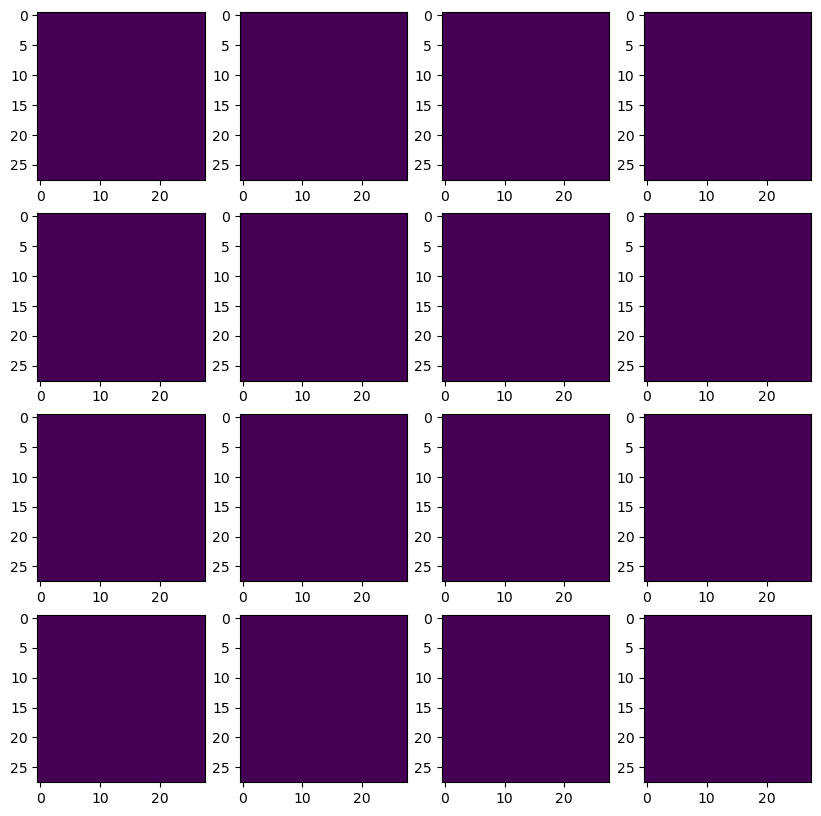

In [103]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4): 
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])